# Neural Language Model (LSTM)

This notebook implements a deep learning-based language model using LSTM (Long Short-Term Memory) networks.

**Objectives:**
- Build an LSTM-based language model
- Train the model to predict the next word given previous tokens
- Generate text from the trained model
- Evaluate performance using loss curves and perplexity

## 1. Import Required Libraries

In [10]:
import pandas as pd
import numpy as np
import re
import nltk
from collections import Counter
import matplotlib.pyplot as plt

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# Text processing
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tokenizers import Tokenizer

import random

# Download NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab', quiet=True)

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cpu
PyTorch version: 2.9.1


## 2. Load and Preprocess Data

In [11]:
# Load dataset
file_path = 'data/spam.csv'
df = pd.read_csv(file_path, encoding='latin-1')

# Keep only relevant columns
df = df[['v1', 'v2']]
df.columns = ['label', 'message']
df['label'] = df['label'].map({'spam': 1, 'ham': 0})

print(f"Dataset loaded: {df.shape[0]} messages")
print(f"Spam: {df['label'].sum()}, Ham: {(df['label']==0).sum()}")
df.head()

Dataset loaded: 5572 messages
Spam: 747, Ham: 4825


,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [12]:
# Text preprocessing functions
def clean_text(text):
    """Clean and normalize text"""
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def tokenize_and_remove_stopwords(text):
    """Tokenize and remove stopwords"""
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return filtered_tokens

def lemmatize_tokens(tokens):
    """Lemmatize tokens"""
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

def preprocess_text(text):
    """Complete preprocessing pipeline"""
    cleaned = clean_text(text)
    tokens = tokenize_and_remove_stopwords(cleaned)
    processed = lemmatize_tokens(tokens)
    return ' '.join(processed)

# Apply preprocessing
print("Preprocessing text...")
df['processed_message'] = df['message'].apply(preprocess_text)
print("✓ Preprocessing complete")

Preprocessing text...
✓ Preprocessing complete
✓ Preprocessing complete


## 3. Train BPE Tokenizer

In [13]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace

# Initialize BPE tokenizer
tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
tokenizer.pre_tokenizer = Whitespace()

# Configure trainer
trainer = BpeTrainer(
    vocab_size=5000,
    special_tokens=["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"],
    min_frequency=2
)

# Train BPE tokenizer
training_data = df['processed_message'].tolist()
print("Training BPE tokenizer...")
tokenizer.train_from_iterator(training_data, trainer=trainer)
tokenizer.save("bpe_tokenizer.json")
print("✓ BPE tokenizer trained and saved")

# Apply tokenization
df['bpe_tokens'] = df['processed_message'].apply(lambda x: tokenizer.encode(x).tokens)
print(f"✓ Tokenization complete")

Training BPE tokenizer...



✓ BPE tokenizer trained and saved
✓ Tokenization complete
✓ Tokenization complete


## 4. Prepare Data for Neural Language Model

In [14]:
# Build vocabulary
all_tokens = []
for tokens in df['bpe_tokens']:
    all_tokens.extend(tokens)

token_counts = Counter(all_tokens)
vocab_tokens = ["<PAD>", "<UNK>", "<SOS>", "<EOS>"] + [token for token, count in token_counts.most_common() if count >= 2]
vocab_size = len(vocab_tokens)

token2idx = {token: idx for idx, token in enumerate(vocab_tokens)}
idx2token = {idx: token for token, idx in token2idx.items()}

print(f"Vocabulary size: {vocab_size}")
print(f"Total tokens: {len(all_tokens):,}")
print(f"Unique tokens: {len(token_counts):,}")

Vocabulary size: 4300
Total tokens: 57,308
Unique tokens: 4,572


## 5. Create Dataset for Language Modeling

In [15]:
class LanguageModelDataset(Dataset):
    """
    Dataset for language modeling.
    Creates input sequences and targets (next word).
    """
    def __init__(self, tokenized_texts, token2idx, seq_length=10):
        self.token2idx = token2idx
        self.seq_length = seq_length
        self.sequences = []
        self.targets = []
        
        # Create sequences with sliding window
        for tokens in tokenized_texts:
            if len(tokens) < 2:
                continue
            
            # Add start and end tokens
            tokens = ["<SOS>"] + tokens + ["<EOS>"]
            
            # Convert to indices
            indices = [token2idx.get(token, token2idx["<UNK>"]) for token in tokens]
            
            # Create sequences
            for i in range(len(indices) - 1):
                start_idx = max(0, i - seq_length + 1)
                context = indices[start_idx:i+1]
                
                # Pad if necessary
                if len(context) < seq_length:
                    context = [token2idx["<PAD>"]] * (seq_length - len(context)) + context
                
                target = indices[i + 1]
                
                self.sequences.append(context)
                self.targets.append(target)
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype=torch.long), torch.tensor(self.targets[idx], dtype=torch.long)

# Create dataset
SEQ_LENGTH = 10
dataset = LanguageModelDataset(df['bpe_tokens'].tolist(), token2idx, seq_length=SEQ_LENGTH)

# Split into train and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

print(f"Total sequences: {len(dataset):,}")
print(f"Training sequences: {len(train_dataset):,}")
print(f"Validation sequences: {len(val_dataset):,}")

# Create data loaders
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

Total sequences: 62,704
Training sequences: 50,163
Validation sequences: 12,541
Training batches: 783
Validation batches: 195


## 6. Define LSTM Language Model

In [16]:
class LSTMLanguageModel(nn.Module):
    """
    LSTM-based Language Model for next-word prediction.
    """
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=256, num_layers=2, dropout=0.3):
        super(LSTMLanguageModel, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=token2idx["<PAD>"])
        
        # LSTM layers
        self.lstm = nn.LSTM(
            embedding_dim, 
            hidden_dim, 
            num_layers=num_layers, 
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Output layer
        self.fc = nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, x, hidden=None):
        # Embedding
        embedded = self.embedding(x)
        
        # LSTM
        if hidden is None:
            lstm_out, hidden = self.lstm(embedded)
        else:
            lstm_out, hidden = self.lstm(embedded, hidden)
        
        # Take last output
        lstm_out = lstm_out[:, -1, :]
        
        # Dropout
        lstm_out = self.dropout(lstm_out)
        
        # Output
        output = self.fc(lstm_out)
        
        return output, hidden

# Initialize model
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
NUM_LAYERS = 2
DROPOUT = 0.3

model = LSTMLanguageModel(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
).to(device)

total_params = sum(p.numel() for p in model.parameters())
print("Model Architecture:")
print(model)
print(f"\nTotal parameters: {total_params:,}")

Model Architecture:
LSTMLanguageModel(
  (embedding): Embedding(4300, 128, padding_idx=0)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=4300, bias=True)
)

Total parameters: 2,577,100


## 7. Training Setup

In [17]:
def calculate_perplexity(loss):
    """Calculate perplexity from loss"""
    return torch.exp(loss).item()

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    total_samples = 0
    
    for sequences, targets in dataloader:
        sequences = sequences.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        outputs, _ = model(sequences)
        loss = criterion(outputs, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()
        
        total_loss += loss.item() * sequences.size(0)
        total_samples += sequences.size(0)
    
    return total_loss / total_samples

def validate(model, dataloader, criterion, device):
    """Validate the model"""
    model.eval()
    total_loss = 0
    total_samples = 0
    
    with torch.no_grad():
        for sequences, targets in dataloader:
            sequences = sequences.to(device)
            targets = targets.to(device)
            outputs, _ = model(sequences)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * sequences.size(0)
            total_samples += sequences.size(0)
    
    return total_loss / total_samples

# Loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=token2idx["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Some versions of PyTorch's ReduceLROnPlateau do not accept the `verbose` keyword.
# Use a safe try/except to maintain compatibility across environments.
try:
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
except TypeError:
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

print("Training setup complete!")

Training setup complete!


## 8. Train the Model

In [18]:
NUM_EPOCHS = 20

train_losses = []
val_losses = []
train_perplexities = []
val_perplexities = []
best_val_loss = float('inf')

print("="*60)
print("Training LSTM Language Model")
print("="*60)

for epoch in range(NUM_EPOCHS):
    # Train
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    train_perplexity = calculate_perplexity(torch.tensor(train_loss))
    
    # Validate
    val_loss = validate(model, val_loader, criterion, device)
    val_perplexity = calculate_perplexity(torch.tensor(val_loss))
    
    # Store history
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_perplexities.append(train_perplexity)
    val_perplexities.append(val_perplexity)
    
    # Update learning rate
    scheduler.step(val_loss)
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_lstm_lm.pt')
    
    # Print progress
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f} | Perplexity: {train_perplexity:.2f}")
    print(f"  Val Loss:   {val_loss:.4f} | Perplexity: {val_perplexity:.2f}")
    if val_loss == best_val_loss:
        print("  ✓ Best model saved!")
    print("-"*60)

print("="*60)
print(f"Training complete!")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Best validation perplexity: {calculate_perplexity(torch.tensor(best_val_loss)):.2f}")
print("="*60)

Training LSTM Language Model
Epoch 1/20
  Train Loss: 7.1070 | Perplexity: 1220.49
  Val Loss:   6.8776 | Perplexity: 970.28
  ✓ Best model saved!
------------------------------------------------------------
Epoch 1/20
  Train Loss: 7.1070 | Perplexity: 1220.49
  Val Loss:   6.8776 | Perplexity: 970.28
  ✓ Best model saved!
------------------------------------------------------------
Epoch 2/20
  Train Loss: 6.6554 | Perplexity: 776.94
  Val Loss:   6.6388 | Perplexity: 764.21
  ✓ Best model saved!
------------------------------------------------------------
Epoch 2/20
  Train Loss: 6.6554 | Perplexity: 776.94
  Val Loss:   6.6388 | Perplexity: 764.21
  ✓ Best model saved!
------------------------------------------------------------
Epoch 3/20
  Train Loss: 6.2394 | Perplexity: 512.53
  Val Loss:   6.4591 | Perplexity: 638.47
  ✓ Best model saved!
------------------------------------------------------------
Epoch 3/20
  Train Loss: 6.2394 | Perplexity: 512.53
  Val Loss:   6.4591 | Per

## 9. Plot Training Curves

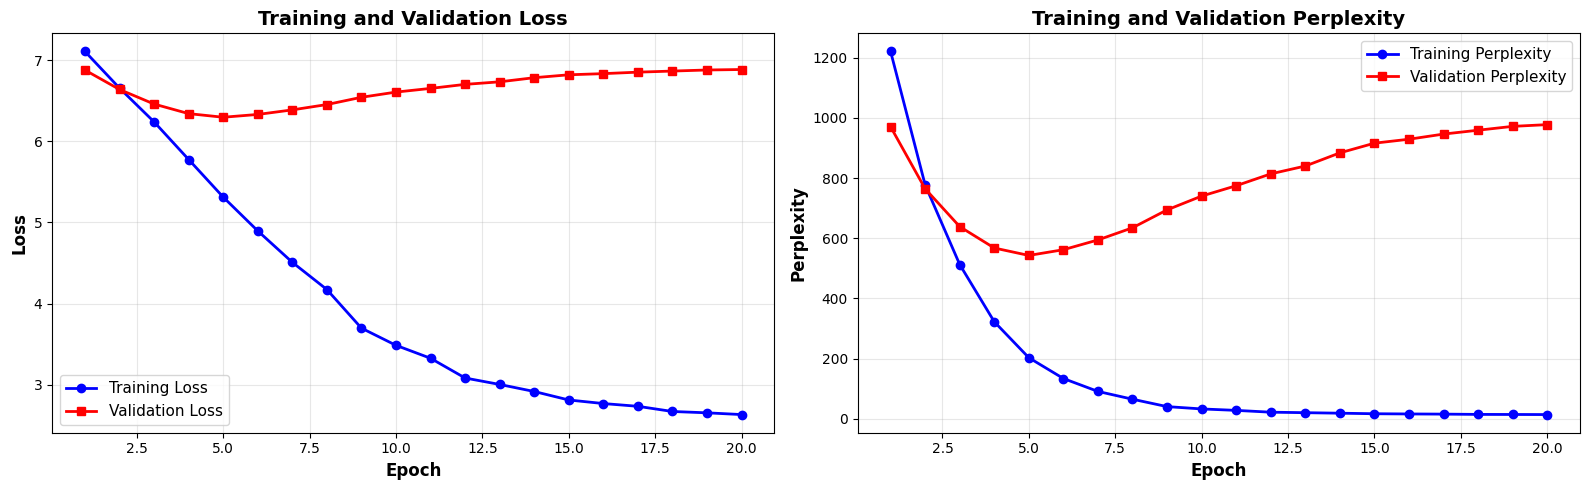

✓ Training curves saved as 'lstm_lm_training_curves.png'


In [19]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

epochs_range = range(1, NUM_EPOCHS + 1)

# Loss curves
ax1 = axes[0]
ax1.plot(epochs_range, train_losses, 'b-o', label='Training Loss', linewidth=2, markersize=6)
ax1.plot(epochs_range, val_losses, 'r-s', label='Validation Loss', linewidth=2, markersize=6)
ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Perplexity curves
ax2 = axes[1]
ax2.plot(epochs_range, train_perplexities, 'b-o', label='Training Perplexity', linewidth=2, markersize=6)
ax2.plot(epochs_range, val_perplexities, 'r-s', label='Validation Perplexity', linewidth=2, markersize=6)
ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax2.set_ylabel('Perplexity', fontsize=12, fontweight='bold')
ax2.set_title('Training and Validation Perplexity', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('lstm_lm_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Training curves saved as 'lstm_lm_training_curves.png'")

## 10. Text Generation Functions

In [20]:
def generate_text(model, seed_text, token2idx, idx2token, max_length=20, temperature=1.0, top_k=50):
    """
    Generate text using the trained LSTM model.
    """
    model.eval()
    
    if isinstance(seed_text, str):
        tokens = seed_text.strip().split()
    else:
        tokens = list(seed_text)
    
    if len(tokens) == 0:
        tokens = ["<SOS>"]
    
    generated_tokens = tokens.copy()
    
    with torch.no_grad():
        for _ in range(max_length):
            input_tokens = tokens[-SEQ_LENGTH:]
            
            if len(input_tokens) < SEQ_LENGTH:
                input_tokens = ["<PAD>"] * (SEQ_LENGTH - len(input_tokens)) + input_tokens
            
            input_indices = [token2idx.get(token, token2idx["<UNK>"]) for token in input_tokens]
            input_tensor = torch.tensor([input_indices], dtype=torch.long).to(device)
            
            output, _ = model(input_tensor)
            logits = output[0] / temperature
            
            if top_k > 0:
                top_k_logits, top_k_indices = torch.topk(logits, min(top_k, logits.size(-1)))
                logits = torch.full_like(logits, float('-inf'))
                logits[top_k_indices] = top_k_logits
            
            probs = F.softmax(logits, dim=-1)
            next_token_idx = torch.multinomial(probs, 1).item()
            next_token = idx2token[next_token_idx]
            
            if next_token == "<EOS>":
                break
            
            if next_token not in ["<PAD>", "<UNK>", "<SOS>"]:
                generated_tokens.append(next_token)
                tokens.append(next_token)
    
    return ' '.join(generated_tokens)

def predict_next_word(model, context, token2idx, idx2token, top_k=5):
    """
    Predict the most likely next words given context.
    """
    model.eval()
    
    if isinstance(context, str):
        tokens = context.strip().split()
    else:
        tokens = list(context)
    
    input_tokens = tokens[-SEQ_LENGTH:]
    if len(input_tokens) < SEQ_LENGTH:
        input_tokens = ["<PAD>"] * (SEQ_LENGTH - len(input_tokens)) + input_tokens
    
    input_indices = [token2idx.get(token, token2idx["<UNK>"]) for token in input_tokens]
    input_tensor = torch.tensor([input_indices], dtype=torch.long).to(device)
    
    with torch.no_grad():
        output, _ = model(input_tensor)
        probs = F.softmax(output[0], dim=-1)
        top_probs, top_indices = torch.topk(probs, top_k)
        
        predictions = []
        for prob, idx in zip(top_probs, top_indices):
            token = idx2token[idx.item()]
            if token not in ["<PAD>", "<UNK>", "<SOS>", "<EOS>"]:
                predictions.append((token, prob.item()))
        
        return predictions

print("Text generation functions defined!")

Text generation functions defined!


## 11. Generate Text Examples

In [21]:
# Load best model
model.load_state_dict(torch.load('best_lstm_lm.pt'))
model.eval()

print("="*80)
print("TEXT GENERATION EXAMPLES")
print("="*80)

# Generate from seed words
seed_texts = ["free", "call", "urgent", "win", "you"]

print("\n📝 Generated Text from Seed Words:\n")
for seed in seed_texts:
    generated = generate_text(model, seed, token2idx, idx2token, max_length=15, temperature=0.8, top_k=40)
    print(f"Seed: '{seed}'")
    print(f"Generated: {generated}")
    print("-"*80)

# Random text generation
print("\n🎲 Random Text Generation (no seed):\n")
for i in range(3):
    generated = generate_text(model, "", token2idx, idx2token, max_length=20, temperature=1.0, top_k=50)
    print(f"{i+1}. {generated}")
    print("-"*80)

# Temperature comparison
print("\n🌡️  Temperature Comparison:\n")
seed = "free"
for temp in [0.5, 1.0, 1.5]:
    generated = generate_text(model, seed, token2idx, idx2token, max_length=15, temperature=temp, top_k=50)
    print(f"Temperature {temp}: {generated}")
print("-"*80)

TEXT GENERATION EXAMPLES

📝 Generated Text from Seed Words:

Seed: 'free'
Generated: free call
--------------------------------------------------------------------------------
Seed: 'call'
Generated: call
--------------------------------------------------------------------------------
Seed: 'urgent'
Generated: urgent n u c meet
--------------------------------------------------------------------------------
Seed: 'win'
Generated: win b used wave ve
--------------------------------------------------------------------------------
Seed: 'you'
Generated: you around
--------------------------------------------------------------------------------

🎲 Random Text Generation (no seed):

1. <SOS> good morning evening
--------------------------------------------------------------------------------
2. <SOS> got car rock
--------------------------------------------------------------------------------
3. <SOS> ìï im get job c u dun wan eat infernal go liao come
--------------------------------------

## 12. Next-Word Prediction Examples

In [22]:
print("="*80)
print("NEXT-WORD PREDICTION EXAMPLES")
print("="*80)

test_contexts = [
    "free",
    "call me",
    "urgent message",
    "you win",
    "claim your"
]

for context in test_contexts:
    predictions = predict_next_word(model, context, token2idx, idx2token, top_k=10)
    print(f"\nContext: '{context}'")
    print("Top 10 next-word predictions:")
    for i, (word, prob) in enumerate(predictions, 1):
        print(f"  {i:2d}. {word:>15s}  probability: {prob:.4f} ({prob*100:.2f}%)")
    print("-"*80)

NEXT-WORD PREDICTION EXAMPLES

Context: 'free'
Top 10 next-word predictions:
   1.            text  probability: 0.0257 (2.57%)
   2.              st  probability: 0.0180 (1.80%)
   3.            week  probability: 0.0176 (1.76%)
   4.            call  probability: 0.0146 (1.46%)
   5.             msg  probability: 0.0124 (1.24%)
   6.         message  probability: 0.0078 (0.78%)
   7.               b  probability: 0.0074 (0.74%)
   8.           reply  probability: 0.0072 (0.72%)
   9.            back  probability: 0.0068 (0.68%)
--------------------------------------------------------------------------------

Context: 'call me'
Top 10 next-word predictions:
   1.               u  probability: 0.0205 (2.05%)
   2.               x  probability: 0.0143 (1.43%)
   3.            dont  probability: 0.0142 (1.42%)
   4.            stop  probability: 0.0130 (1.30%)
   5.               b  probability: 0.0116 (1.16%)
   6.             got  probability: 0.0101 (1.01%)
   7.            care  prob

## 13. Model Evaluation Summary

In [23]:
print("="*80)
print("LSTM LANGUAGE MODEL - EVALUATION SUMMARY")
print("="*80)

print("\n📊 Model Configuration:")
print(f"  Vocabulary Size: {vocab_size:,}")
print(f"  Embedding Dimension: {EMBEDDING_DIM}")
print(f"  Hidden Dimension: {HIDDEN_DIM}")
print(f"  LSTM Layers: {NUM_LAYERS}")
print(f"  Dropout: {DROPOUT}")
print(f"  Sequence Length: {SEQ_LENGTH}")
print(f"  Total Parameters: {total_params:,}")

print("\n📈 Training Results:")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Final Training Loss: {train_losses[-1]:.4f}")
print(f"  Final Validation Loss: {val_losses[-1]:.4f}")
print(f"  Best Validation Loss: {best_val_loss:.4f}")
print(f"  Final Training Perplexity: {train_perplexities[-1]:.2f}")
print(f"  Final Validation Perplexity: {val_perplexities[-1]:.2f}")
print(f"  Best Validation Perplexity: {calculate_perplexity(torch.tensor(best_val_loss)):.2f}")

print("\n💾 Saved Files:")
print("  - best_lstm_lm.pt")
print("  - lstm_lm_training_curves.png")
print("  - bpe_tokenizer.json")

print("\n🎯 Model Capabilities:")
print("  ✓ Next-word prediction")
print("  ✓ Text generation with temperature control")
print("  ✓ Top-k sampling")
print("  ✓ Handles unknown tokens")

print("="*80)

LSTM LANGUAGE MODEL - EVALUATION SUMMARY

📊 Model Configuration:
  Vocabulary Size: 4,300
  Embedding Dimension: 128
  Hidden Dimension: 256
  LSTM Layers: 2
  Dropout: 0.3
  Sequence Length: 10
  Total Parameters: 2,577,100

📈 Training Results:
  Epochs: 20
  Final Training Loss: 2.6322
  Final Validation Loss: 6.8849
  Best Validation Loss: 6.2966
  Final Training Perplexity: 13.90
  Final Validation Perplexity: 977.41
  Best Validation Perplexity: 542.72

💾 Saved Files:
  - best_lstm_lm.pt
  - lstm_lm_training_curves.png
  - bpe_tokenizer.json

🎯 Model Capabilities:
  ✓ Next-word prediction
  ✓ Text generation with temperature control
  ✓ Top-k sampling
  ✓ Handles unknown tokens
